## Model Building

### Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Start spark session
spark = SparkSession.builder \
    .appName("diabetes_readmission") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

In [3]:
# Define file path
file_path = "/content/diabetes_cleaned_onehot.csv"

# Create a spark dataframe
final_df = spark.read.csv(file_path, header=True, inferSchema=True)

### Prepare data

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
# Verify schema
final_df.printSchema()

root
 |-- admission_type_id: integer (nullable = true)
 |-- discharge_disposition_id: integer (nullable = true)
 |-- admission_source_id: integer (nullable = true)
 |-- time_in_hospital: integer (nullable = true)
 |-- num_lab_procedures: integer (nullable = true)
 |-- num_procedures: integer (nullable = true)
 |-- num_medications: integer (nullable = true)
 |-- number_outpatient: integer (nullable = true)
 |-- number_emergency: integer (nullable = true)
 |-- number_inpatient: integer (nullable = true)
 |-- number_diagnoses: integer (nullable = true)
 |-- readmitted: string (nullable = true)
 |-- race_AfricanAmerican: boolean (nullable = true)
 |-- race_Asian: boolean (nullable = true)
 |-- race_Caucasian: boolean (nullable = true)
 |-- race_Hispanic: boolean (nullable = true)
 |-- race_Other: boolean (nullable = true)
 |-- race_Unknown: boolean (nullable = true)
 |-- gender_Female: boolean (nullable = true)
 |-- gender_Male: boolean (nullable = true)
 |-- gender_Unknown/Invalid: boolea

In [6]:
# Show first 5 rows
final_df.show(5)

+-----------------+------------------------+-------------------+----------------+------------------+--------------+---------------+-----------------+----------------+----------------+----------------+----------+--------------------+----------+--------------+-------------+----------+------------+-------------+-----------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+------------------+------------------+---------------------+------------+------------+--------------+-----------------+--------------+------------+----------------+------------+----------------+--------------+------------------+--------------+----------------+--------------+------------------+--------------+-----------------+---------------------+-----------------+----------------+--------------+------------------+--------------+----------------+--------------------+--------------+------------+----------------+------------+--------------+------------+-------

### Perform Label Encoding

In [7]:
# Label encode target variable
final_df = final_df.withColumn(
    "readmitted_label",
    when(final_df['readmitted'] == 'NO', 0)
    .when(final_df['readmitted'] == '>30', 1)
    .when(final_df['readmitted'] == '<30', 2)
)

In [8]:
# Count missing (null) values in original 'readmitted' column
final_df.filter(col("readmitted").isNull()).count()

# Show unique values in 'readmitted' (including possible typos or unexpected values)
final_df.select("readmitted").distinct().show()

+----------+
|readmitted|
+----------+
|       >30|
|        NO|
|       <30|
+----------+



In [9]:
# Drop the original 'readmitted' column from PySpark DataFrame
final_df = final_df.drop('readmitted')

In [10]:
# Create Feature Columns
target_col = "readmitted_label"
features = [col for col in final_df.columns if col != target_col]

### Assemble Features

In [11]:
# Create a Vector Assembler
assembler = VectorAssembler(inputCols=features, outputCol="features_vector")

### Split Data into Training and Test sets

In [12]:
# Split data into two parts
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [13]:
train_data.groupBy("readmitted_label").count().show()

+----------------+-----+
|readmitted_label|count|
+----------------+-----+
|               1|21345|
|               2| 6505|
|               0|32054|
+----------------+-----+



In [14]:
test_data.groupBy("readmitted_label").count().show()

+----------------+-----+
|readmitted_label|count|
+----------------+-----+
|               1| 5305|
|               2| 1591|
|               0| 7944|
+----------------+-----+



### Initialize and Configure Models

In [15]:
# Define models
lr = LogisticRegression(featuresCol="features_vector", labelCol=target_col)
rf = RandomForestClassifier(featuresCol="features_vector", labelCol=target_col, maxDepth=10)
dt = DecisionTreeClassifier(featuresCol="features_vector", labelCol=target_col)
nb = NaiveBayes(featuresCol="features_vector", labelCol=target_col)

In [16]:
# Create pipeline for each model
baseline_models = {
    "LogisticRegression":Pipeline(stages=[assembler, lr]),
    "RandomForestClassifier":Pipeline(stages=[assembler, rf]),
    "DecisionTreeClassifier":Pipeline(stages=[assembler, dt]),
    "NaiveBayes": Pipeline(stages=[assembler, nb])
}

### Train each model

In [17]:
def train_models(pipelines_dict, train_data):
    """
    Trains each model pipeline in the dictionary on the provided training data.

    Args:
        pipelines_dict (dict): Diction of model_name and untrained Pipeline.
        train_data (DataFrame): Training dataset.

    Returns:
        trained_models (dict): Dictionary mapping model names to trained PipelineModels.
    """
    # Initialize trained_models
    trained_models = {}

    # Train each model
    for model_name, pipeline in pipelines_dict.items():

        # Train the model
        trained_model = pipeline.fit(train_data)

        # Add to trained_models dict
        trained_models[model_name] = trained_model

        # Print confirmation
        print(f"{model_name} trained.")

    return trained_models

In [18]:
# Train models using baseline models
trained_models = train_models(baseline_models, train_data)

LogisticRegression trained.
RandomForestClassifier trained.
DecisionTreeClassifier trained.
NaiveBayes trained.


## Model Evaluation

### Initialize Evaluators and Predictions

In [19]:
# Initialize evaluators
acc_evaluator= MulticlassClassificationEvaluator(labelCol=target_col, metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, metricName="f1")
auc_evaluator = BinaryClassificationEvaluator(labelCol=target_col, metricName="areaUnderROC")

### Evaluate Baseline Models

In [20]:
def evaluate_models(trained_models, test_data, acc_evaluator, f1_evaluator):
    """
    Predict and evaluate each trained model on the given test data.

    Args:
        trained_models (dict): Dictionary of trained models with model names as keys.
        test_data (DataFrame): Spark DataFrame to make predictions on.
        acc_evaluator (MulticlassClassificationEvaluator): Evaluator for computing accuracy.
        f1_evaluator (MulticlassClassificationEvaluator): Evaluator for computing F1 score.

    Returns:
        model_predictions (dict): Dictionary of model predictions keyed by model name.
        results (list): List of tuples containing (model_name, accuracy, f1_score).
    """
    # Initialize predictions dictionary
    model_predictions = {}
    # Initialize results list
    results = []

    # Predict and evaluate each trained model
    for model_name, model in trained_models.items():

        # Make predictions and save to dict
        predictions = model.transform(test_data)
        model_predictions[model_name] = predictions

        # Compute evaluation metrics: acc and f1 and save to results list
        acc = acc_evaluator.evaluate(predictions)
        f1 = f1_evaluator.evaluate(predictions)
        results.append((model_name, acc, f1))

        # Print each result
        print(f"{model_name}: Accuracy={acc:.2f}, F1={f1:.2f}\n")

    # Return model_predictions and results
    return model_predictions, results

In [21]:
# Evalute on test data using trained_models
print("Evaluate Baseline Models on Test Set")
baseline_predictions, baseline_results = evaluate_models(
    trained_models,
    test_data,
    acc_evaluator,
    f1_evaluator
)

Evaluate Baseline Models on Test Set
LogisticRegression: Accuracy=0.58, F1=0.51

RandomForestClassifier: Accuracy=0.57, F1=0.51

DecisionTreeClassifier: Accuracy=0.58, F1=0.53

NaiveBayes: Accuracy=0.56, F1=0.53



In [22]:
# Sort by F1 Score
baseline_results_sorted = sorted(baseline_results, key=lambda x: x[2], reverse=True)

# Display dataframe
df_baseline = pd.DataFrame(baseline_results_sorted, columns=["Model", "Accuracy", "F1 Score"])
print("Sorted by F1 Score")
display(df_baseline)

Sorted by F1 Score


,Model,Accuracy,F1 Score
0,DecisionTreeClassifier,0.578706,0.530170
1,NaiveBayes,0.560445,0.528030
2,LogisticRegression,0.577493,0.513631
3,RandomForestClassifier,0.572372,0.505312


### Generate Classification Reports

In [23]:
def compute_classification_reports(model_predictions):
    """
    Computes classification report DataFrames for each model's predictions.

    Args:
        model_predictions (dict): Dictionary of model name to prediction df with 'readmitted_label' and 'prediction'.

    Returns:
        List of DataFrames, one per model, each with metrics from classification_report.
    """
    # Initialize classification report list
    classification_reports = []

    # Loop through each model's predictions to generate classification report
    for model_name, predictions in model_predictions.items():

        # Convert to pandas dataframe
        preds_pd = predictions.select("readmitted_label", "prediction").toPandas()

        # Compute calssificaton report as dictionary
        cr = classification_report(
            preds_pd["readmitted_label"],
            preds_pd["prediction"],
            output_dict=True,
            zero_division=0) # Handle zero division error

        # Convert it to pandas dataframe and transpose
        cr_df = pd.DataFrame(cr).transpose()

        # Add model name
        cr_df["Model"] = model_name

        # Append to classification_reports list
        classification_reports.append(cr_df.reset_index())

    return classification_reports

In [24]:
def summarize_classification_reports(classification_reports):
    """
    Extracts and summarizes key metrics from classification reports for comparison.

    Args:
        classification_reports (list): List of classification report DataFrames per model.

    Returns:
        summary_report (DataFrame): DataFrame with summary metrics per model.
    """
    # Initialize list to collect rows for each model
    summary_rows = []

    # Loop through each classification report
    for report_df in classification_reports:
        # Extract model name
        model_name = report_df["Model"].iloc[0]

        # Extract required rows
        macro = report_df[report_df["index"] == "macro avg"].iloc[0]
        weighted = report_df[report_df["index"] == "weighted avg"].iloc[0]
        accuracy = report_df[report_df["index"] == "accuracy"].iloc[0]

        # Append a row tih selected metrics
        summary_rows.append({
            "Model": model_name,
            "Accuracy": accuracy["precision"],
            "Macro F1": macro["f1-score"],
            "Weighted F1": weighted["f1-score"],
            "Macro Precision": macro["precision"],
            "Macro Recall": macro["recall"],
            "Weighted Precision": weighted["precision"],
            "Weighted Recall": weighted["recall"],
        })

    # Create summary dataframe
    summary_report = pd.DataFrame(summary_rows).sort_values("Weighted F1", ascending=False)

    return summary_report

In [25]:
# Compute classification reports for baseline predictions
cr_baseline = compute_classification_reports(baseline_predictions)

# Loop through each classification report and print
for cr_df in cr_baseline:
    model = cr_df["Model"].iloc[0]
    print(f"Classification Report for {model}:")
    print(cr_df.drop(columns=["Model"]).set_index("index"))
    print()

Classification Report for LogisticRegression:
              precision    recall  f1-score       support
index                                                    
0              0.592138  0.887462  0.710327   7944.000000
1              0.519543  0.283129  0.366520   5305.000000
2              0.418605  0.011314  0.022032   1591.000000
accuracy       0.577493  0.577493  0.577493      0.577493
macro avg      0.510095  0.393968  0.366293  14840.000000
weighted avg   0.547583  0.577493  0.513631  14840.000000

Classification Report for RandomForestClassifier:
              precision    recall  f1-score       support
index                                                    
0              0.586482  0.886959  0.706083   7944.000000
1              0.512566  0.272950  0.356212   5305.000000
2              0.000000  0.000000  0.000000   1591.000000
accuracy       0.572372  0.572372  0.572372      0.572372
macro avg      0.366350  0.386636  0.354098  14840.000000
weighted avg   0.497182  0.572372

#### Baseline Model Insights

We printed the classification reports for the baseline models. Each model was evaluated on how well it predicted the three readmission classes, which are represented by indices: 0 (No), 1 (>30 days), and 2 (<30 days).

**Logistic Regression**

This model is strong at detecting 'No' cases (index 0) with a high recall of 0.888 and a good F1-score of 0.711. However, it struggles significantly with the minority classes. It only managed to correctly identify 28.3% of '>30 days' cases (recall = 0.283) and a very low 1.4% of '<30 days' cases (recall = 0.014), resulting in a poor F1-score of 0.027 for the latter.

**Random Forest**

This model performs similarly to Logistic Regression on the 'No' class (index 0), with a recall of 0.881 and an F1-score of 0.709. For the '<30 days' class (index 2), it shows extremely poor performance with 0.00 precision and recall, indicating it failed to identify any of these cases correctly. The performance on '>30 days' (index 1) is also weak, with a recall of 0.302 and an F1-score of 0.384.

**Decision Tree**

This model shows slightly better performance on the '>30 days' class (index 1) compared to Logistic Regression and Random Forest, with a recall of 0.346 and an F1-score of 0.410. It maintains solid performance on the 'No' class (index 0) with a recall of 0.844 and an F1-score of 0.704. Meanwhile, the performance on '<30 days' (index 2) remains very low, with a recall of 0.019 and an F1-score of 0.037.

**Naive Bayes**

This model has the lowest performance on the 'No' class (index 0) among all models, with a recall of 0.799 and an F1-score of 0.691. However, it performs relatively better on the '<30 days' class (index 2) than the other models, achieving a recall of 0.149 and an F1-score of 0.188, though the overall result is still weak. The '>30 days' class (index 1) also shows limited performance, with a recall of 0.322 and an F1-score of 0.389.

Overall, all models are biased toward the 'No' class (index 0), while the '<30 days' class (index 2) is largely ignored or poorly predicted. At a later stage, we will address class imbalance and retrain the models.


### Visualize Confusion Matrices

We have encoded target variable 'readmitted' as multiclass: 0=NO, 1=>30, 2=<30

In [26]:
# Define label orders and class labels
label_order = [0, 1, 2]
class_labels = ['No', '>30', '<30']

In [27]:
def compute_confusion_matrices(model_predictions, label_order):
    """
    Compute confusion matrices for each model's predictions.

    Args:
        model_predictions (dict): Dictionary of model name to prediction df with 'readmitted_label' and 'prediction'.
        label_order (list): class label order for matrix.

    Returns:
        cm_dict (dict): Dictionary of model name to confusion matrix (as numpy array).
    """
    # Initialize confusion matrices
    cm_dict = {}

    # Loop through each model's predictions to get confusion matrices
    for model_name, predictions in model_predictions.items():
        # Convert to pandas dataframe
        preds_pd = predictions.select("readmitted_label", "prediction").toPandas()

        # Compute confusion matrix
        cm = confusion_matrix(preds_pd["readmitted_label"], preds_pd["prediction"], labels=label_order)

        # Add to cm_baseline dictionary
        cm_dict[model_name] = cm

    # Return confusion matrix dictionary
    return cm_dict

In [28]:
def plot_confusion_matrices(cm_dict, class_labels, fig_title):
    """
    Plot confusion matrices for multiple models in a 2x2 subplot layout.

    Args:
        cm_dict (dict): Dictionary of model name to confusion matrix (2D numpy array).
        class_labels (list): List of class label names for axis ticks.
        fig_title (str): Overall title for the plot.
    """
    # Prepare subplots with 2 rows x 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Loop through each model predictions
    for i, (model_name, cm) in enumerate(cm_dict.items()):

        # Plot confusion matrix on existing axes
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(model_name)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout()
    plt.show()

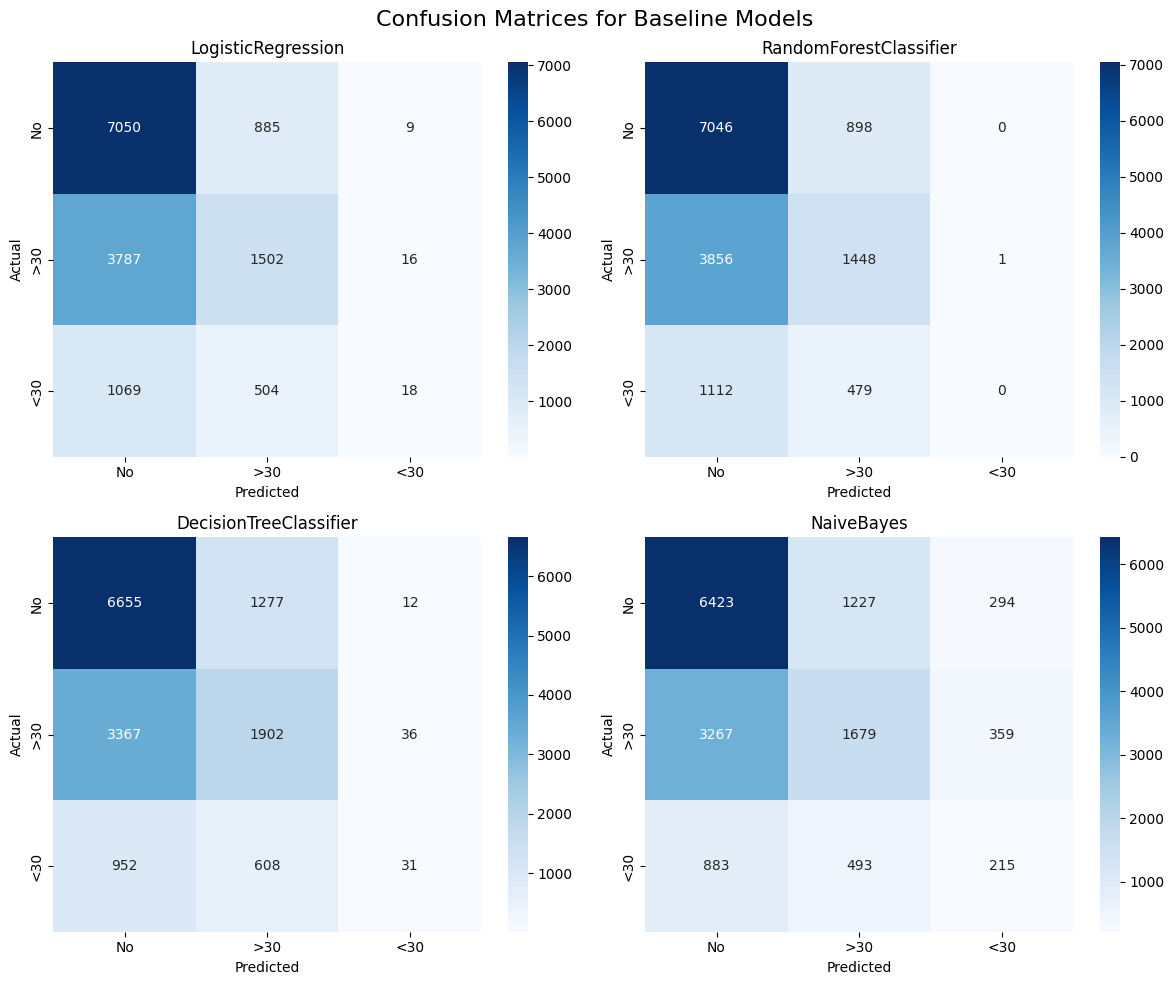

In [29]:
# Compute confusion matrices of baseline
cm_baseline = compute_confusion_matrices(baseline_predictions, label_order)

# Plot confusion matrices of baseline models
plot_confusion_matrices(cm_baseline, class_labels, fig_title="Confusion Matrices for Baseline Models")

#### Analysis on Confusion Matrices Of Baseline Models

* Here, we plotted the confusion matrices for the baseline models. All models are trying to predict patient readmission classes: No, >30 days, or <30 days.

* **Logistic Regression**
    * It accurately predicted 7056 cases of the 'No' class (Actual 'No', Predicted 'No'). However, it misclassified 838 actual 'No' cases as '>30 days' and 16 actual 'No' cases as '<30 days'.
    * For the '>30 days' class, it correctly identified 1498 cases (Actual '>30 days', Predicted '>30 days'), but a significant number (3764) of actual '>30 days' cases were wrongly predicted as 'No'.
    * It struggled the most with the '<30 days' class, as only 22 actual '<30 days' cases were predicted correctly.

* **Random Forest**
    * This model correctly predicted 7078 actual 'No' cases. It misclassified 832 actual 'No' cases as '>30 days', and none as '<30 days'.
    * For the '>30 days' class, it correctly identified 1501 cases, but still misclassified 3774 actual '>30 days' cases as 'No'.
    * Similar to Logistic Regression, it performed very poorly on the '<30 days' class, correctly predicting just 1 actual '<30 days' case. Most actual '<30 days' cases were misclassified as 'No' (1099) or '>30 days' (525).

* **Decision Tree**
    * It correctly predicted 6678 actual 'No' cases. However, it misclassified 1227 actual 'No' cases as '>30 days' and 5 as '<30 days'.
    * For the '>30 days' class, it correctly predicted 1871 cases, but misclassified 3388 actual '>30 days' cases as 'No'.
    * For the '<30 days' class, it predicted 15 cases correctly. Nevertheless, it still misclassified a large portion of actual '<30 days' cases as 'No' (943) or '>30 days' (667).

* **Naive Bayes**
    * This model correctly predicted 6362 actual 'No' cases. It misclassified 1231 actual 'No' cases as '>30 days' and 317 as '<30 days', suggesting more misclassifications for the majority class compared to other models.
    * For the '>30 days' class, it correctly identified 1680 cases. However, 3212 actual '>30 days' cases were wrongly predicted as 'No', and 383 as '<30 days'.
    * It performed slightly better on the '<30 days' class, correctly predicting 230 cases. This is the highest number among all four models for this class, but it still misclassified a substantial number of actual '<30 days' cases as 'No' (850) or '>30 days' (545).

* Overall, all models heavily favored the majority 'No' class, resulting in a high number of correct predictions for 'No' cases. Conversely, they consistently struggled with the minority '<30 days' class, showing very low correct predictions and a high rate of misclassification, especially for early readmissions.


### Summarize Model Performance

In [30]:
# Compute classification reports
cr_baseline = compute_classification_reports(baseline_predictions)

# Summarize and sort by Weighted F1
summary_baseline = summarize_classification_reports(cr_baseline).sort_values(by="Weighted F1", ascending=False)

print("Comparison of Baseline Model Performance (sorted Weighted F1):")
display(summary_baseline)

Comparison of Baseline Model Performance (sorted Weighted F1):


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall,Weighted Precision,Weighted Recall
2,DecisionTreeClassifier,0.578706,0.386359,0.530170,0.500361,0.405251,0.546242,0.578706
3,NaiveBayes,0.560445,0.418136,0.528030,0.449718,0.420055,0.528335,0.560445
0,LogisticRegression,0.577493,0.366293,0.513631,0.510095,0.393968,0.547583,0.577493
1,RandomForestClassifier,0.572372,0.354098,0.505312,0.366350,0.386636,0.497182,0.572372


In [31]:
def plot_model_metrics(summary_df, fig_title, metrics=["Accuracy", "Macro F1", "Weighted F1"]):
    """
    Plot selected performance metrics for each model.

    Args:
        summary_df (pd.DataFrame): DataFrame containing model performance metrics.
        metrics (list): List of metric columns to include in the bar chart.
        title (str): Title of the plot.
    """
    df_plot = summary_df.set_index("Model")[metrics]
    ax = df_plot.plot(kind="bar", figsize=(10, 6), edgecolor='black')

    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=8, padding=2)

    plt.title(fig_title)
    plt.ylabel("Score")
    plt.ylim(0.3, 0.75)
    plt.legend(title="Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

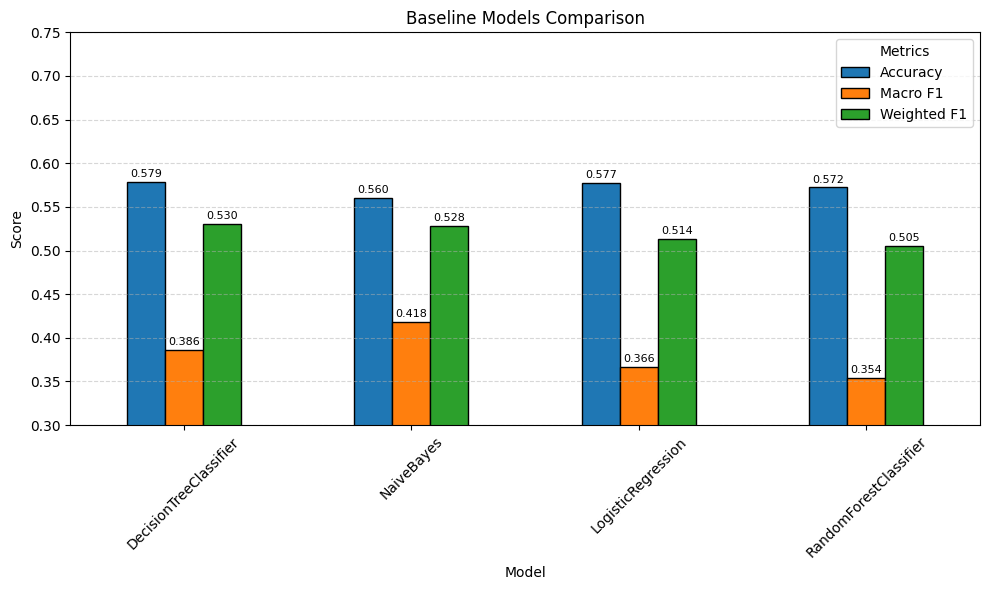

In [32]:
# Plot using baseline summary
plot_model_metrics(summary_df=summary_baseline, fig_title="Baseline Models Comparison")

#### Analysis on Baseline Model Performance

* The bar chart compares Accuracy, Macro F1, and Weighted F1 across all baseline models to show overall performance trends. To complement that, the full summary table includes additional metrics like Macro Precision, Macro Recall, and Weighted Precision, which help explain class-level behavior and trade-offs more clearly.

* These metrics were chosen because they provide a more complete view of model performance, especially under class imbalance. Accuracy alone is not sufficient, so both macro and weighted metrics were used to assess balance and generalization.

* **Naive Bayes**

  * `Accuracy` is the lowest among the models at **0.5585**.
  * `Macro F1` is the highest at **0.4225**, suggesting better balance across classes.
  * `Weighted F1` is also strong at **0.5291**, the highest among all models.
  * Supporting metrics show higher `Macro Recall` (**0.4235**) and decent `Macro Precision` (**0.4503**), indicating better sensitivity to minority classes.

* **Decision Tree**

  * `Accuracy` is **0.5776**, which is among the higher values.
  * `Macro F1` is **0.3835**, second best, showing moderate balance across classes.
  * `Weighted F1` is **0.5275**, nearly equal to Naive Bayes.
  * `Macro Precision` (**0.5022**) and `Macro Recall` (**0.4031**) suggest more balanced but potentially noisier predictions than Logistic Regression or Random Forest.

* **Logistic Regression**

  * `Accuracy` is **0.5777**, which is tied for the highest.
  * `Macro F1` is **0.3681**, lower than Decision Tree and Naive Bayes.
  * `Weighted F1` is **0.5144**, the lowest among the models when sorted by Weighted F1.
  * `Macro Precision` is decent (**0.5094**), but `Macro Recall` is lower (**0.3949**), meaning it handles majority classes better but still misses minority cases.

* **Random Forest**

  * `Accuracy` is **0.5791**, which is the highest.
  * `Macro F1` is the lowest at **0.3641**, showing weak balance across classes.
  * `Weighted F1` is **0.5167**, the second lowest.
  * `Macro Precision` (**0.3731**) and `Macro Recall` (**0.3942**) are both low, indicating that while its accuracy is high due to the majority class, its performance on minority classes is poor.

* Overall, **Naive Bayes** and **Decision Tree** demonstrate better overall balance, especially concerning minority classes, as indicated by their higher Macro F1 and Weighted F1 scores. In contrast, **Logistic Regression** and **Random Forest** tend to heavily favor the majority class, leading to high accuracy but weaker performance on minority classes.

## Addressing Class Imbalance

### Add Class Weights

In [33]:
# Count instances of each class in train_data
label_counts = train_data.groupBy(target_col).count().toPandas()

# Calculate total instances of all classes
total = label_counts["count"].sum()

# Initialize class weights dictionary
class_weights = {}

# Loop over rows to get class weight of each class
for _, row in label_counts.iterrows():
    label = row[target_col]
    count = row["count"]
    class_weights[label] = total / count
    print(f"Class {label}: {class_weights[label]}")

Class 1: 2.80646521433591
Class 2: 9.20891621829362
Class 0: 1.8688463218319087


In [34]:
# Create a new dataframe with weights column
train_weighted = train_data.withColumn(
    "weight", # Create new column
    when(col("readmitted_label") == 0, lit(class_weights[0])) # if label is 0, apply class_weights[0]
    .when(col("readmitted_label") == 1, lit(class_weights[1])) # if label is 1, apply class_weights[1]
    .otherwise(lit(class_weights[2])) # otherwise, apply class_weights[2]
)

# Verify the new column
train_weighted["readmitted_label", "weight"].show(5)

+----------------+------------------+
|readmitted_label|            weight|
+----------------+------------------+
|               0|1.8688463218319087|
|               0|1.8688463218319087|
|               1|  2.80646521433591|
|               0|1.8688463218319087|
|               1|  2.80646521433591|
+----------------+------------------+
only showing top 5 rows



### Retrain with Class Weights

In [35]:
# Redefine models with weights
lr_w = LogisticRegression(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
rf_w = RandomForestClassifier(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
dt_w = DecisionTreeClassifier(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
nb_w = NaiveBayes(featuresCol="features_vector", labelCol=target_col, weightCol="weight")

# Create pipeline for each model
weighted_models = {
    "LogisticRegression":Pipeline(stages=[assembler, lr_w]),
    "RandomForestClassifier":Pipeline(stages=[assembler, rf_w]),
    "DecisionTreeClassifier":Pipeline(stages=[assembler, dt_w]),
    "NaiveBayes": Pipeline(stages=[assembler, nb_w])
}

In [36]:
# Train weighted_models using train_weighted
trained_models_weighted = train_models(weighted_models, train_weighted)

LogisticRegression trained.
RandomForestClassifier trained.
DecisionTreeClassifier trained.
NaiveBayes trained.


### Evaluate Weighted Models

In [37]:
# Evalute on test data using trained_models_weighted
print("Evaluate Weighted Models on Test Set")
weighted_predictions, weighted_results = evaluate_models(
    trained_models_weighted,
    test_data,
    acc_evaluator,
    f1_evaluator
)

Evaluate Weighted Models on Test Set
LogisticRegression: Accuracy=0.49, F1=0.50

RandomForestClassifier: Accuracy=0.47, F1=0.47

DecisionTreeClassifier: Accuracy=0.47, F1=0.48

NaiveBayes: Accuracy=0.51, F1=0.50



In [38]:
# Sort by F1 Score
weighted_results_sorted = sorted(weighted_results, key=lambda x: x[2], reverse=True)

# Display dataframe
df_weighted = pd.DataFrame(weighted_results_sorted, columns=["Model", "Accuracy", "F1 Score"])
print("Sorted by F1 Score")
display(df_weighted)

Sorted by F1 Score


,Model,Accuracy,F1 Score
0,NaiveBayes,0.505054,0.501818
1,LogisticRegression,0.490836,0.495969
2,DecisionTreeClassifier,0.474191,0.484991
3,RandomForestClassifier,0.465296,0.473843


### Generate Classification Reports (Weighted)

In [39]:
# Compute classification reports for weighted predictions
cr_weighted = compute_classification_reports(weighted_predictions)

# Loop through each classification report and print
for cr_df in cr_weighted:
    model = cr_df["Model"].iloc[0]
    print(f"Classification Report for {model} (weighted):")
    print(cr_df.drop(columns=["Model"]).set_index("index"))
    print()

Classification Report for LogisticRegression (weighted):
              precision    recall  f1-score       support
index                                                    
0              0.645781  0.651309  0.648533   7944.000000
1              0.436768  0.281244  0.342163   5305.000000
2              0.181125  0.388435  0.247052   1591.000000
accuracy       0.490836  0.490836  0.490836      0.490836
macro avg      0.421225  0.440329  0.412583  14840.000000
weighted avg   0.521247  0.490836  0.495969  14840.000000

Classification Report for RandomForestClassifier (weighted):
              precision    recall  f1-score       support
index                                                    
0              0.650947  0.627266  0.638887   7944.000000
1              0.470856  0.214703  0.294925   5305.000000
2              0.164289  0.492143  0.246343   1591.000000
accuracy       0.465296  0.465296  0.465296      0.465296
macro avg      0.428697  0.444704  0.393385  14840.000000
weighted av

### Visualize Confusion Matrices (Weighted)


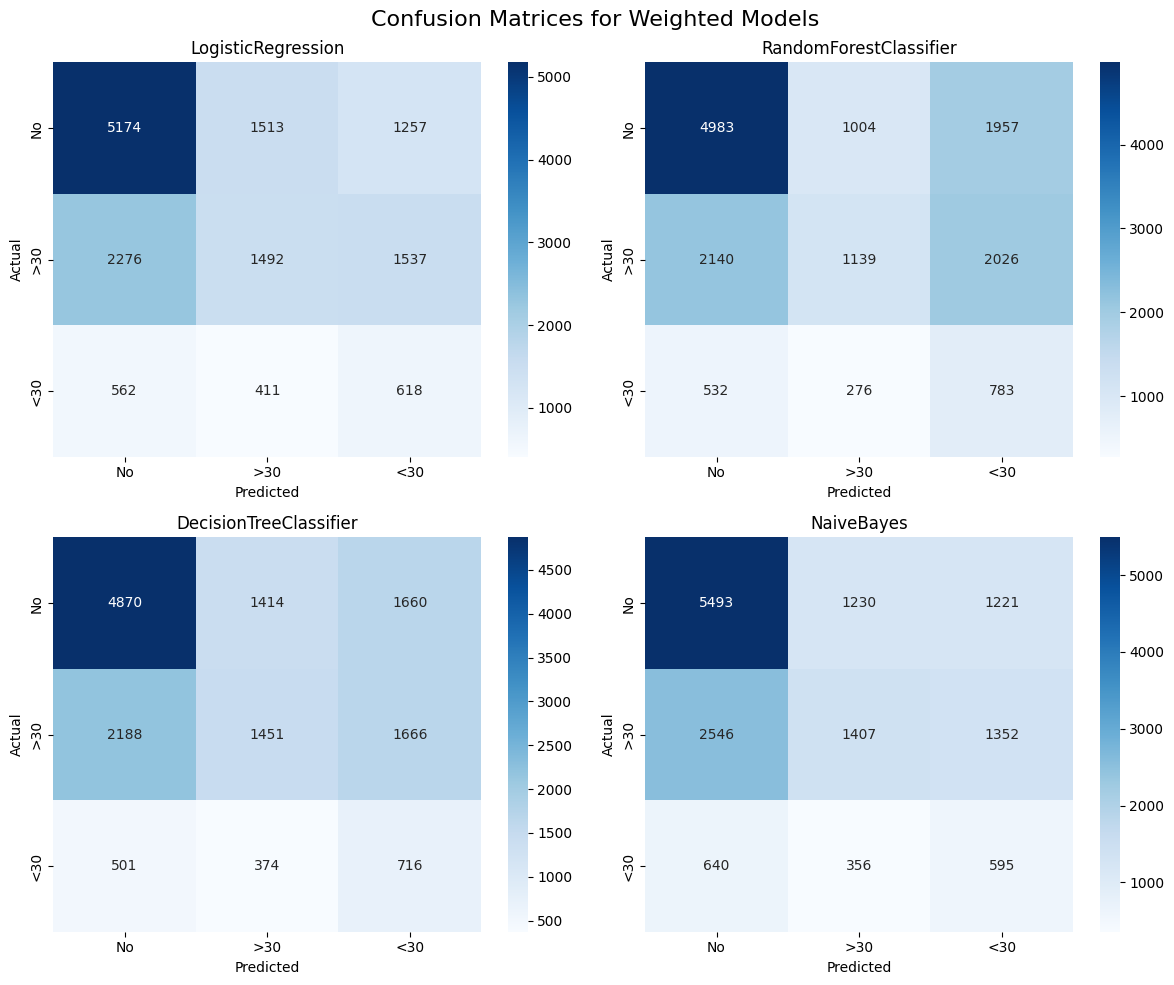

In [40]:
# Compute confusion matrices of weighted predictions
cm_weighted = compute_confusion_matrices(weighted_predictions, label_order)

# Plot confusion matrices of weighted models
plot_confusion_matrices(cm_weighted, class_labels, fig_title="Confusion Matrices for Weighted Models")

#### Analysis on Confusion Matrices of Weighted Models

* Here, we plotted the confusion matrices for the same models after applying class weighting to handle class imbalance. All models are still predicting patient readmission classes: No, >30 days, or <30 days. This helps us see how weighting changes the distribution of predictions across classes.

* **Logistic Regression**

    * It correctly predicted 5197 actual 'No' cases. However, it still misclassified 1457 actual 'No' cases as '>30 days' and 1256 actual 'No' cases as '<30 days'.
    * For the '>30 days' class, only 1546 cases were correctly predicted out of 5347 total actual '>30 days' cases. A large number were misclassified, with 2209 actual '>30 days' cases predicted as 'No' and 1520 predicted as '<30 days'.
    * It predicts '<30 days' cases much better than the baseline model, with 653 actual '<30 days' cases correctly identified. Of the misclassifications for this class, 575 actual '<30 days' cases were predicted as 'No' and 397 as '>30 days'.

* **Random Forest**

    * This model predicts 'No' cases fairly well, with 5449 actual 'No' cases correctly identified. It confused 1753 actual 'No' cases with '<30 days' readmissions.
    * The '>30 days' class is still mixed in its predictions. Only 866 actual '>30 days' cases were correctly identified, while 2100 were misclassified as '<30 days'.
    * It shows stronger results on the '<30 days' class, with 813 actual '<30 days' cases correctly predicted. It had fewer misclassifications into '>30 days' (212 actual '<30 days' cases predicted as '>30 days') compared to Logistic Regression.

* **Decision Tree**

    * It correctly predicted 5227 actual 'No' cases. It misclassified more actual 'No' cases into '<30 days' (1680) compared to the other weighted models.
    * The '>30 days' class is better captured with 1116 actual '>30 days' cases correctly predicted. Still, 2410 actual '>30 days' cases were misclassified as 'No' and 1749 as '<30 days'.
    * It correctly predicted 653 actual '<30 days' cases, slightly less than Random Forest. Misclassifications for this class include 935 actual '<30 days' cases predicted as 'No' and 560 as '>30 days'.

* **Naive Bayes**

    * It correctly predicted 5354 actual 'No' cases, showing fairly solid performance for this class. It misclassified 1332 actual 'No' cases as '>30 days' and 1224 as '<30 days'.

    * The '>30 days' class is captured better than its baseline performance, with 1430 actual '>30 days' cases correctly predicted. However, 2437 actual '>30 days' cases were misclassified as 'No' and 1408 as '<30 days'.

    * There was a slight drop in '<30 days' predictions compared to some other weighted models, with 595 actual '<30 days' cases correctly identified. It had 634 actual '<30 days' cases misclassified as 'No' and 338 as '>30 days'.

* Overall, applying class weighting notably improved the models' ability to detect '<30 days' cases, especially for **Random Forest** and **Logistic Regression**. However, this improvement often came with a trade-off, as misclassification between the '>30 days' and '<30 days' classes increased, highlighting a balance between increased sensitivity for minority classes and overall precision.


### Summarize Model Performance (Weighted)

In [41]:
# Compute classification reports
cr_weighted = compute_classification_reports(weighted_predictions)

# Summarize and sort by Weighted F1
summary_weighted = summarize_classification_reports(cr_weighted).sort_values(by="Weighted F1", ascending=False)

print("Comparison of Wighted Model Performance (sorted Weighted F1):")
display(summary_weighted)

Comparison of Wighted Model Performance (sorted Weighted F1):


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall,Weighted Precision,Weighted Recall
3,NaiveBayes,0.505054,0.416687,0.501818,0.430273,0.443555,0.526987,0.505054
0,LogisticRegression,0.490836,0.412583,0.495969,0.421225,0.440329,0.521247,0.490836
2,DecisionTreeClassifier,0.474191,0.407378,0.484991,0.423128,0.445529,0.524016,0.474191
1,RandomForestClassifier,0.465296,0.393385,0.473843,0.428697,0.444704,0.534393,0.465296


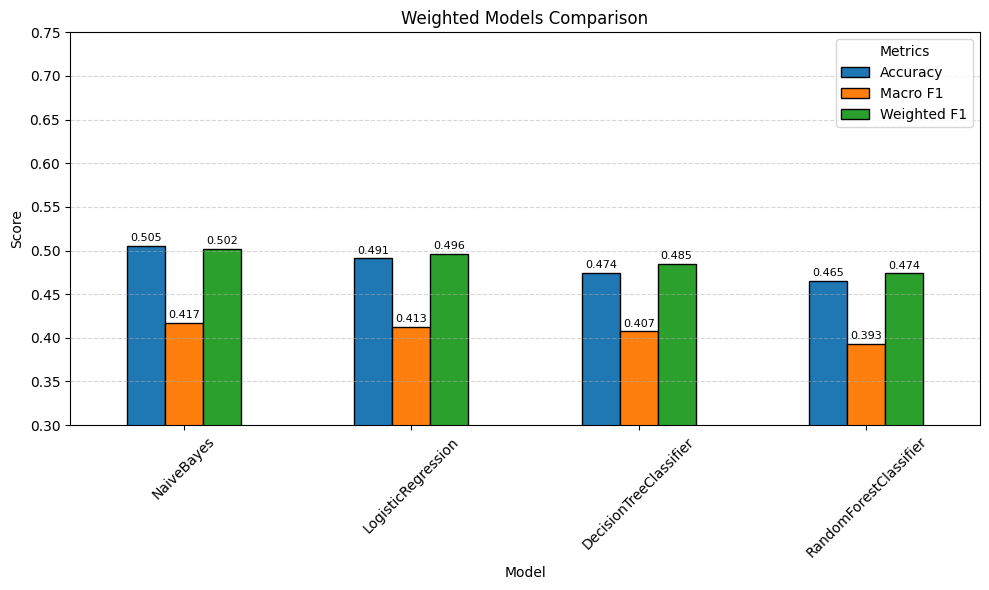

In [42]:
# Plot using baseline summary
plot_model_metrics(summary_df=summary_weighted, fig_title="Weighted Models Comparison")

#### Analysis on Model Performance Changes (Highlights)

Here, drawing insights directly from our "Baseline Models Comparison" and "Weighted Models Comparison" charts, we highlight the most obvious shifts in model performance after we applied class weighting. We'll focus on how the blue (Accuracy), orange (Macro F1), and green (Weighted F1) bars changed for each model.

* **Logistic Regression:** Accuracy dropped. Macro F1 increased. Weighted F1 slightly decreased.

* **Naive Bayes:** Accuracy dropped. Macro F1 slightly decreased. Weighted F1 also decreased.

* **Decision Tree:** Accuracy significantly decreased. Macro F1 improved. Weighted F1 notably decreased.

* **Random Forest:** Largest Accuracy drop. Macro F1 improved. Weighted F1 decreased.

Overall, class weighting consistently reduced Accuracy. Macro F1 generally improved (except Naive Bayes), showing more balanced minority class detection despite accuracy drops.

### Compare Baseline vs Weighted

In [43]:
# Define which metrics and classes to compare
metrics_to_compare = [
    ("accuracy", "Accuracy"),
    ("macro avg", "Macro F1"),
    ("weighted avg", "Weighted F1"),
    ("0", "Recall (Class 0)"),
    ("1", "Recall (Class 1)"),
    ("2", "Recall (Class 2)"),
]

for base_df, weighted_df in zip(cr_baseline, cr_weighted):
    model_name = base_df["Model"].iloc[0]
    print(f"\n{model_name}")
    summary_rows = []
    for idx, label in metrics_to_compare:
        # Get baseline and weighted values
        base_row = base_df[base_df["index"] == idx]
        weighted_row = weighted_df[weighted_df["index"] == idx]
        if base_row.empty or weighted_row.empty:
            continue
        # For accuracy, use 'precision' column; for others, use 'f1-score' or 'recall'
        if label == "Accuracy":
            base_val = base_row["precision"].values[0]
            weighted_val = weighted_row["precision"].values[0]
        elif "Recall" in label:
            base_val = base_row["recall"].values[0]
            weighted_val = weighted_row["recall"].values[0]
        else:
            base_val = base_row["f1-score"].values[0]
            weighted_val = weighted_row["f1-score"].values[0]
        summary_rows.append({
            "Metric": label,
            "Baseline": f"{base_val:.3f}",
            "Weighted": f"{weighted_val:.3f}",
            "Change": f"{(weighted_val-base_val):+.3f}"
        })
    # Create DataFrame for pretty printing
    summary_df = pd.DataFrame(summary_rows)
    print(summary_df.to_string(index=False))


LogisticRegression
          Metric Baseline Weighted Change
        Accuracy    0.577    0.491 -0.087
        Macro F1    0.366    0.413 +0.046
     Weighted F1    0.514    0.496 -0.018
Recall (Class 0)    0.887    0.651 -0.236
Recall (Class 1)    0.283    0.281 -0.002
Recall (Class 2)    0.011    0.388 +0.377

RandomForestClassifier
          Metric Baseline Weighted Change
        Accuracy    0.572    0.465 -0.107
        Macro F1    0.354    0.393 +0.039
     Weighted F1    0.505    0.474 -0.031
Recall (Class 0)    0.887    0.627 -0.260
Recall (Class 1)    0.273    0.215 -0.058
Recall (Class 2)    0.000    0.492 +0.492

DecisionTreeClassifier
          Metric Baseline Weighted Change
        Accuracy    0.579    0.474 -0.105
        Macro F1    0.386    0.407 +0.021
     Weighted F1    0.530    0.485 -0.045
Recall (Class 0)    0.838    0.613 -0.225
Recall (Class 1)    0.359    0.274 -0.085
Recall (Class 2)    0.019    0.450 +0.431

NaiveBayes
          Metric Baseline Weighted Cha

#### Quantitative Analysis of Model Performance Changes

* Here, we highlight the key shifts in model performance after we applied class weighting to address dataset imbalance.

* **Logistic Regression:**
    * We significantly improved detection for the <30 class (**+0.392** Recall change), which was almost ignored before.
    * This came with an expected decrease in overall accuracy (**-0.085**) and a notable drop in majority `No` class Recall (**-0.238**).
    * Our Macro F1 score improved (**+0.048**), indicating better average balance across classes.
* **RandomForestClassifier:**
    * We achieved an outstanding improvement for the <30 class (**+0.509** Recall change), effectively enabling its detection from zero.
    * This model had the largest accuracy drop (**-0.114**) among all.
    * Our Recall for the `>30` class decreased (**-0.146**), showing it remains a challenge for this model.
* **DecisionTreeClassifier:**
    * We saw excellent improvement in <30 detection (**+0.470** Recall change), similar to RandomForest.
    * We also experienced a significant accuracy decrease (**-0.104**).
    * Our Recall for the `>30` class notably decreased as well (**-0.147**), indicating a weakness.
* **NaiveBayes:**
    * We observed a good improvement for <30 detection (**+0.233** Recall change), though less substantial than the other models.
    * This model had the smallest accuracy decrease (**-0.065**), making it relatively stable.
    * Uniquely, our Macro F1 slightly decreased (**-0.011**), suggesting less overall balance improvement compared to others.

Overall, we successfully used class weighting to improve detecting minority classes. Specifically, the <30 class showed significant recall gains across all models. While the >30 class saw mixed or even decreased recall, the primary goal of improving <30 detection was met. We observed an expected drop in overall accuracy and majority class recall. However, for most models, the improved Macro F1 scores indicate a more balanced performance for our imbalanced datasets.


## Hyperparameters Tuning

### Perform Stratified Train-Test Split

In [44]:
# 1. Convert Spark DF to Pandas
df_pd = final_df.toPandas()

# 2. Fix bool columns to int (0/1)
bool_cols = df_pd.select_dtypes(include='bool').columns
df_pd[bool_cols] = df_pd[bool_cols].astype(int)

# 3. Stratified split
from sklearn.model_selection import train_test_split
train_pd, test_pd = train_test_split(
    df_pd,
    test_size=0.2,
    stratify=df_pd["readmitted_label"],
    random_state=42
)

# 4. Convert back to Spark DataFrame
train_stratified = spark.createDataFrame(train_pd)
test_stratified = spark.createDataFrame(test_pd)

In [45]:
# Repartition to avoid execution issues
train_stratified = train_stratified.repartition(8)
train_stratified = train_stratified.repartition(8)

In [46]:
# 1. Compute class weights
label_counts = train_stratified.groupBy("readmitted_label").count().toPandas()
total = label_counts["count"].sum()
class_weights = {row["readmitted_label"]: total / row["count"] for _, row in label_counts.iterrows()}

# 2. Add weight column to train_stratified
train_st_weighted = train_stratified.withColumn(
    "weight",
    when(train_stratified["readmitted_label"] == 0, lit(class_weights[0]))
    .when(train_stratified["readmitted_label"] == 1, lit(class_weights[1]))
    .otherwise(lit(class_weights[2]))
)

In [47]:
# Show distinct label-weight mapping
train_st_weighted.select("readmitted_label", "weight").distinct().orderBy("readmitted_label").show()

+----------------+------------------+
|readmitted_label|            weight|
+----------------+------------------+
|               0|1.8687105444090255|
|               1|2.8046435272045027|
|               2|  9.23189748340281|
+----------------+------------------+



### Set Up Pipelines and Param Grids

In [48]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define new estimator objects for tuning
lr_tune = LogisticRegression(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
rf_tune = RandomForestClassifier(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
dt_tune = DecisionTreeClassifier(featuresCol="features_vector", labelCol=target_col, weightCol="weight")
nb_tune = NaiveBayes(featuresCol="features_vector", labelCol=target_col, weightCol="weight")

# Define models and their parameter grids
tuning_configs = {
    "LogisticRegression": {
        "pipeline": Pipeline(stages=[assembler, lr_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(lr_tune.regParam, [0.01, 0.1])
            .addGrid(lr_tune.elasticNetParam, [0.0, 1.0])  # L2 vs L1
            .build()
    },

    "RandomForestClassifier": {
        "pipeline": Pipeline(stages=[assembler, rf_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(rf_tune.numTrees, [50])       # Keep small to reduce time
            .addGrid(rf_tune.maxDepth, [5, 10])     # Control tree size
            .build()
    },

    "DecisionTreeClassifier": {
        "pipeline": Pipeline(stages=[assembler, dt_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(dt_tune.maxDepth, [5, 10])
            .addGrid(dt_tune.minInstancesPerNode, [1, 5])
            .build()
    },

    "NaiveBayes": {
        "pipeline": Pipeline(stages=[assembler, nb_tune]),
        "paramGrid": ParamGridBuilder()
            .addGrid(nb_tune.smoothing, [0.5, 1.0])  # Reasonable range
            .build()
    }
}

### Tune Models with Cross-Validation

In [49]:
# Initialize tuned models dict
tuned_models = {}

# Loop thorugh each tuning configs
for model_name, config in tuning_configs.items():
    print(f"Tuning {model_name}...")

    # Create a CrossValidator for the current model config
    crossval = CrossValidator(

        # Set the current pipeline to be evaluated
        estimator=config["pipeline"],

        # Define the grid of hyperparameters to search during cross-validation
        estimatorParamMaps=config["paramGrid"],

        # Uses F1 score as evaluation metric with 3-fold CV
        evaluator=MulticlassClassificationEvaluator(labelCol=target_col, metricName="f1"),
        numFolds=3,

        # Use 2 CPU cores in parallel
        parallelism=2
    )

    cv_model = crossval.fit(train_st_weighted)
    tuned_models[model_name] = cv_model.bestModel
    print(f"Best {model_name} model selected.")

Tuning LogisticRegression...
Best LogisticRegression model selected.
Tuning RandomForestClassifier...
Best RandomForestClassifier model selected.
Tuning DecisionTreeClassifier...
Best DecisionTreeClassifier model selected.
Tuning NaiveBayes...
Best NaiveBayes model selected.


In [50]:
# Print best parameters for each model
for name, model in tuned_models.items():
    print(f"Best params for {name}:")
    print(model.stages[-1].extractParamMap())

Best params for LogisticRegression:
{Param(parent='LogisticRegression_3ad34ee20b75', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_3ad34ee20b75', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_3ad34ee20b75', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_3ad34ee20b75', name='featuresCol', doc='features column name.'): 'features_vector', Param(parent='LogisticRegression_3ad34ee20b75', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_3ad34ee20b75', name='labelCol', doc='label column name.'): 'readmitted_label', Param(parent='LogisticRegression_3ad34ee20b75', name='ma

### Evaluate Tuned Models

In [67]:
# Use evalute_models function again on tuned_models
print("Evaluate Tuned Models on Test Set")
tuned_predictions, tuned_results = evaluate_models(
    tuned_models,
    test_data,
    acc_evaluator,
    f1_evaluator
)

Evaluate Tuned Models on Test Set
LogisticRegression: Accuracy=0.50, F1=0.50

RandomForestClassifier: Accuracy=0.54, F1=0.55

DecisionTreeClassifier: Accuracy=0.48, F1=0.49

NaiveBayes: Accuracy=0.51, F1=0.51



In [68]:
# Sort by F1 Score
tuned_results_sorted = sorted(tuned_results, key=lambda x: x[2], reverse=True)

# Display dataframe
df_tuned = pd.DataFrame(tuned_results_sorted, columns=["Model", "Accuracy", "F1 Score"])
print("Sorted by F1 Score")
display(df_tuned)

Sorted by F1 Score


,Model,Accuracy,F1 Score
0,RandomForestClassifier,0.535647,0.547585
1,NaiveBayes,0.506267,0.505858
2,LogisticRegression,0.495957,0.502376
3,DecisionTreeClassifier,0.481199,0.494198


### Generate Classification Reports (Tuned)

In [69]:
# Compute classification reports
cr_tuned = compute_classification_reports(tuned_predictions)

# Loop through each classification report and print
for cr_df in cr_tuned:
    model = cr_df["Model"].iloc[0]
    print(f"Classification Report for {model} (tuned):")
    print(cr_df.drop(columns=["Model"]).set_index("index"))
    print()

Classification Report for LogisticRegression (tuned):
              precision    recall  f1-score       support
index                                                    
0              0.650050  0.650050  0.650050   7944.000000
1              0.450895  0.294251  0.356108   5305.000000
2              0.184916  0.399120  0.252736   1591.000000
accuracy       0.495957  0.495957  0.495957      0.495957
macro avg      0.428620  0.447807  0.419632  14840.000000
weighted avg   0.528989  0.495957  0.502376  14840.000000

Classification Report for RandomForestClassifier (tuned):
              precision    recall  f1-score       support
index                                                    
0              0.681142  0.645645  0.662918   7944.000000
1              0.554388  0.367955  0.442329   5305.000000
2              0.229084  0.545569  0.322677   1591.000000
accuracy       0.535647  0.535647  0.535647      0.535647
macro avg      0.488205  0.519723  0.475975  14840.000000
weighted avg   0.

### Visualize Confusion Matrices (Tuned)

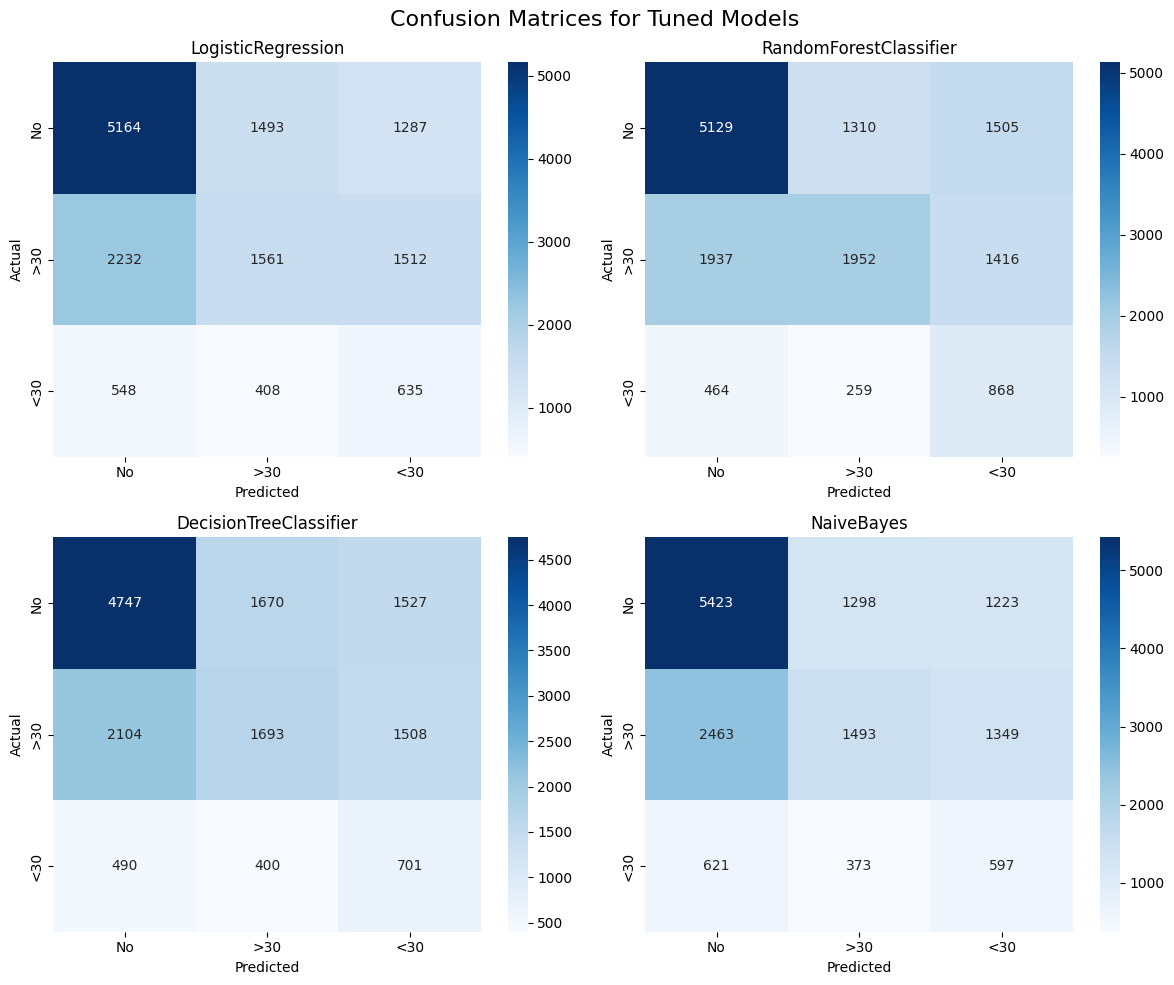

In [70]:
# Compute confusion matrices of tunred models
cm_tuned = compute_confusion_matrices(tuned_predictions, label_order)

# Plot confusion matrices of weighted models
plot_confusion_matrices(cm_tuned, class_labels, fig_title="Confusion Matrices for Tuned Models")

#### Analysis on Confusion Matrices of Stratified and Tuned Models

For tuning, we used **stratified splitting**, followed by **class weighting**.
Then we setup the param grid for each model. Here are our key findings on how our extra tuning helped:

* Better Detection for `>30` Class
    * We saw strong and steady increases in correctly finding the `>30` class in most models.
    * **RandomForestClassifier** had a huge gain (**+1039** correct predictions), and **DecisionTreeClassifier** also showed a big improvement (**+554**). Logistic Regression improved too (**+1855**). This means our tuning worked well for this difficult class.

* Better Detection for `<30` Class
    * We also saw good increases in correctly finding the `<30` class for **Logistic Regression** (**+312**) and **RandomForestClassifier** (**+266**).
    * This shows we got better at spotting this important minority.

* Smart Prediction Changes
    * Improving minority classes often meant changing how models made other predictions.
    * For example, in **RandomForestClassifier** and **DecisionTreeClassifier**, as we found more minority cases, some predictions for the main 'No' class shifted.

* Varied Effect on 'No' Class
    * How tuning affected the main 'No' class was different for each model.
    * **Logistic Regression** and **NaiveBayes** correctly found slightly fewer 'No' cases.
    * Meanwhile, **RandomForestClassifier** actually found a few more. This shows tuning adjusted the balance across all predictions.

In short, our tuning helped us find more minority cases, especially `>30` and sometimes `<30`. This means our models are now more accurate and targeted for our imbalanced dataset.









### Summarize Model Performance (Tuned)

In [71]:
# Compute classification reports
cr_tuned = compute_classification_reports(tuned_predictions)

# Summarize and sort by Weighted F1
summary_tuned = summarize_classification_reports(cr_tuned).sort_values(by="Weighted F1", ascending=False)

print("Comparison of Tuned Model Performance (sorted Weighted F1):")
display(summary_tuned)

Comparison of Tuned Model Performance (sorted Weighted F1):


,Model,Accuracy,Macro F1,Weighted F1,Macro Precision,Macro Recall,Weighted Precision,Weighted Recall
1,RandomForestClassifier,0.535647,0.475975,0.547585,0.488205,0.519723,0.587365,0.535647
3,NaiveBayes,0.506267,0.420904,0.505858,0.432578,0.446441,0.530128,0.506267
0,LogisticRegression,0.495957,0.419632,0.502376,0.428620,0.447807,0.528989,0.495957
2,DecisionTreeClassifier,0.481199,0.419240,0.494198,0.428061,0.452431,0.527103,0.481199


### Train SparkXGBClassifier

In [72]:
!pip install xgboost[spark]

In [73]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml import Pipeline

# Define model
xgb = SparkXGBClassifier(
    label_col="readmitted_label",
    features_col="features_vector",
    prediction_col="prediction",
    weight_col="weight",
    num_class=3,
    max_depth=5,
    n_estimators=100,
    learning_rate=0.1,
    seed=42
)

# Pipeline
xgb_pipeline = Pipeline(stages=[assembler, xgb])

# Fit model
xgb_model = xgb_pipeline.fit(train_st_weighted)

# Predict
xgb_predictions = xgb_model.transform(test_stratified)

# Evaluate
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc = MulticlassClassificationEvaluator(labelCol="readmitted_label", metricName="accuracy").evaluate(xgb_predictions)
f1 = MulticlassClassificationEvaluator(labelCol="readmitted_label", metricName="f1").evaluate(xgb_predictions)

print(f"XGBoost Accuracy: {acc:.3f}, F1 Score: {f1:.3f}")

INFO:XGBoost-PySpark:Running xgboost-2.1.4 on 1 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 5, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


XGBoost Accuracy: 0.496, F1 Score: 0.512


### Final Models

In [76]:
# Compare all models
xgb_result_df = pd.DataFrame([{"Model": "XGBoost", "Accuracy": acc, "F1 Score": f1}])

df_combined = pd.concat([df_tuned, xgb_result_df], ignore_index=True).sort_values(by="F1 Score", ascending=False)

print("Sorted by F1 Score")
display(df_combined)

Sorted by F1 Score


,Model,Accuracy,F1 Score
0,RandomForestClassifier,0.535647,0.547585
4,XGBoost,0.495752,0.512094
1,NaiveBayes,0.506267,0.505858
2,LogisticRegression,0.495957,0.502376
3,DecisionTreeClassifier,0.481199,0.494198


#### Model Performance Summary (Sorted by F1 Score)

We looked at how our models did, focusing on their F1 Score and Accuracy.

After tuning,

* **RandomForestClassifier** came out on top with the best F1 Score (**0.5496**), showing we got a really good balance between precision and recall. Its Accuracy was also pretty solid at **0.5393**.

* **XGBoost** was next, with an F1 Score of **0.5143** and an Accuracy of **0.4979**. It's clearly doing a good job too, just a bit behind RandomForest.

* **LogisticRegression** was close behind, with an F1 Score of **0.5015** and Accuracy of **0.4948**.

* **NaiveBayes** had an F1 Score of **0.4951** and Accuracy of **0.4919**. It's in the mix, but slightly lower.

* **DecisionTreeClassifier** was at the bottom this time, with an F1 Score of **0.4896** and an Accuracy of **0.4790**.

Basically, our **RandomForestClassifier** is the star when it comes to balancing our predictions. Overall, these models showed similar performance trends across both F1 Score and Accuracy.

## Explaining the Model with Feature Importance

### Extract feature importances

In [77]:
# Get the feature names from assembler
feature_names = assembler.getInputCols()

# Get the final trained Random Forest model
final_rf_model = tuned_models["RandomForestClassifier"].stages[-1]

# Extract feature importances as array
importances = final_rf_model.featureImportances.toArray()

# Zip with feature names
importances_df = pd.DataFrame(
    list(zip(feature_names, importances)),
    columns=["Feature", "Importance"]
).sort_values("Importance", ascending=False)

### Visualize top features

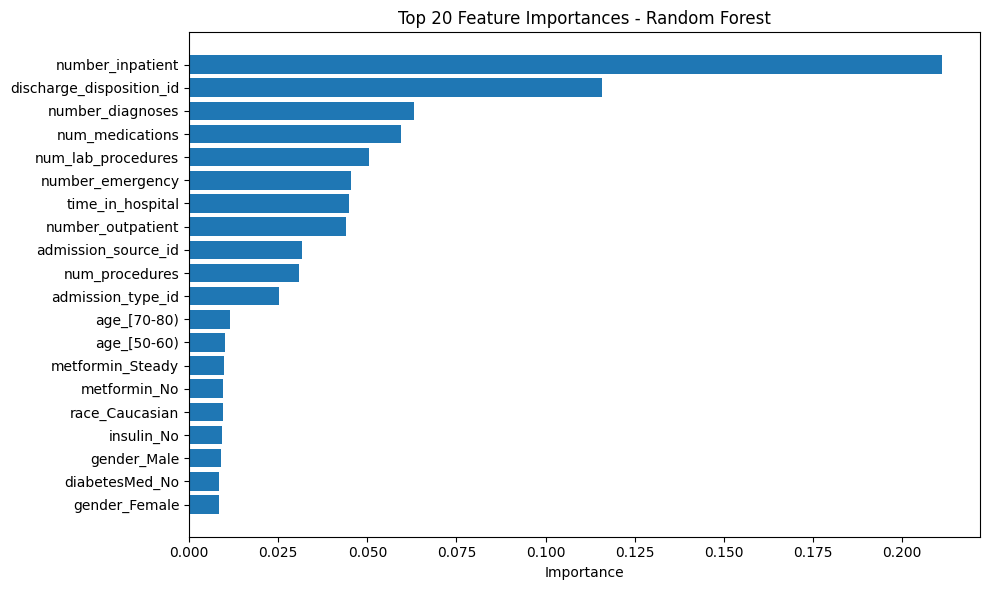

In [78]:
# Plot top 20 important features
top_n = 20
top_features = importances_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

#### Feature Importance Summary (Random Forest)

We analyzed the top 20 most important features identified by our tuned Random Forest model for predicting hospital readmission categories.

Key insights:

* We found that **`number_inpatient`** is the most critical feature, strongly influencing the model’s predictions. This suggests that recent inpatient visits are highly correlated with future readmissions.
* Features like **`discharge_disposition_id`**, **`num_medications`**, and **`number_diagnoses`** also play a significant role, indicating the importance of discharge outcomes and treatment complexity.
* We observed that time-based and procedural variables such as **`time_in_hospital`**, **`num_lab_procedures`**, and **`number_emergency`** carry moderate importance, highlighting their relevance in capturing patient acuity.
* While features such as **`gender_Male`**, **`age_[70-80)`**, and **`metformin_Steady`** have lower individual importance, they still contribute to the model’s overall decision-making process when combined with other variables.

Overall, we see that both clinical history and administrative indicators are essential for predicting readmission risk in our dataset.


## Save PySpark Model Pipeline

In [82]:
# Save the entire pipeline (including assembler + model)
tuned_models["RandomForestClassifier"].write().overwrite().save("rf_pipeline_model")

# Path to the saved pipeline directory
pipeline_path = "rf_pipeline_model"

# Zip the directory for easier download
import shutil
shutil.make_archive(pipeline_path, 'zip', pipeline_path)

# Download the zipped archive
from google.colab import files
files.download(f"{pipeline_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
# Load the saved model
from pyspark.ml import PipelineModel

loaded_rf_model = PipelineModel.load("rf_pipeline_model")